# Проект: Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

In [1]:
#data = pd.read_csv('###')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data['Tenure'] = data['Tenure'].fillna(-1)

<b>Выкинем из данных ненужные признаки: RowNumber, CustomerId, Surname. Они не имеют ценности и только усложнят кодирование признаков и обучение</b>

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

<b>Выполним кодирование категориальных признаков с помощью One Hot Encoding(Для не tree классификаторов)</b>

In [6]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [7]:
data_ohe.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


<b>Для классификаторов Tree-класса выполним кодирование с помощью Ordinal Encoding</b>

In [8]:
category = ['Geography', 'Gender']

In [9]:
encoder = OrdinalEncoder()
encoder.fit(data[category])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [10]:
data_ordinal = data
temp_ordinal = pd.DataFrame(encoder.transform(data[category]),
                            columns=category)

In [11]:
data_ordinal[category] = temp_ordinal

<b>На всякий случай проверим данные на мультиколлинеарность</b>

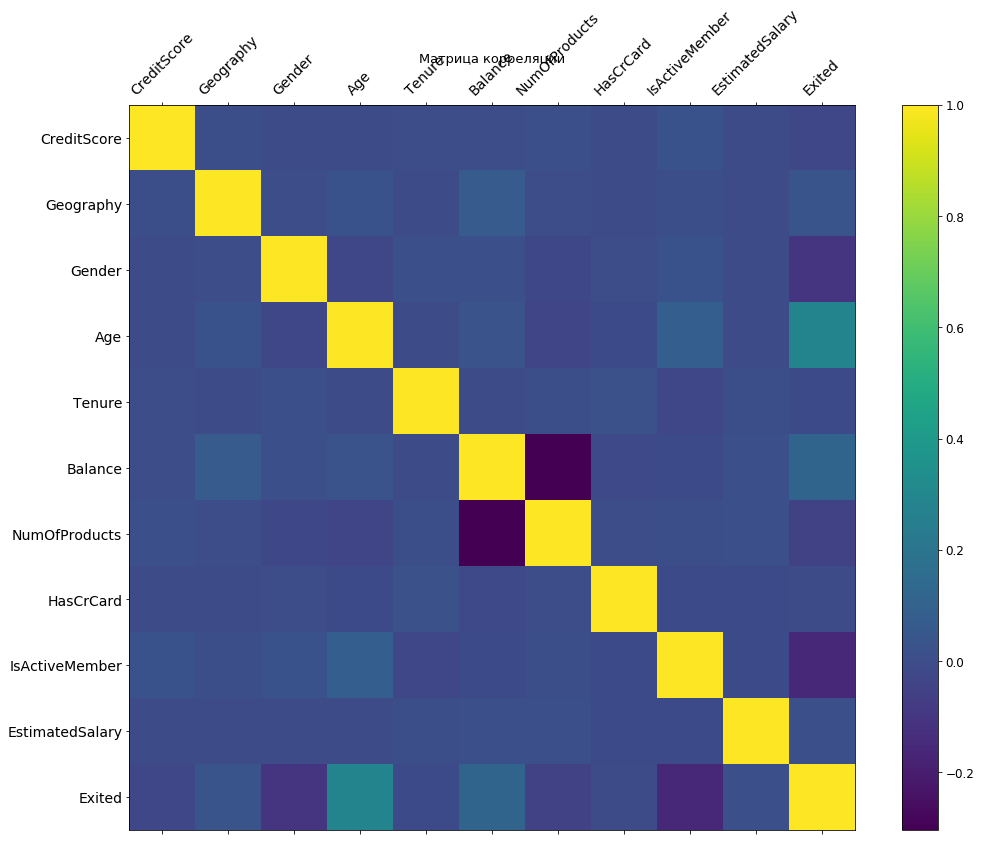

In [12]:
f = plt.figure(figsize=(17, 13))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Матрица корреляции', fontsize=13);

<b>Вывод:</b>
Сильной взаимосвязи между признаками нет, поэтому все столбцы остаются на месте

<b>Выделим признаки, которые нужно отмасштабировать</b>

In [13]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

<b>Создадим модель для масштабирования</b>

In [14]:
scaler = StandardScaler()

<b>Разобьём данные на тренировочные и тестовые в data_ohe<b/>

In [15]:
data_ohe_general, data_ohe_test = train_test_split(data_ohe, test_size = 0.20, random_state=12345)

In [16]:
ohe_features = data_ohe_general.drop(['Exited'], axis=1)
ohe_target = data_ohe_general['Exited']

In [17]:
features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(ohe_features, 
                                                                              ohe_target, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [18]:
test_ohe_features = data_ohe_test.drop(['Exited'], axis=1)
test_ohe_target = data_ohe_test['Exited']

In [19]:
print(test_ohe_features.shape, test_ohe_target.shape)

(2000, 11) (2000,)


<b>Сделаем тоже самое для data_ordinal</b>

In [20]:
data_ordinal_general, data_ordinal_test = train_test_split(data_ordinal, test_size = 0.20, random_state=123456)

In [21]:
ordinal_features = data_ordinal_general.drop(['Exited'], axis=1)
ordinal_target = data_ordinal_general['Exited']

In [22]:
features_ordinal_train, features_ordinal_valid, target_ordinal_train, target_ordinal_valid = train_test_split(ordinal_features, 
                                                                              ordinal_target, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [23]:
test_ordinal_features = data_ordinal_test.drop(['Exited'], axis=1)
test_ordinal_target = data_ordinal_test['Exited']

In [24]:
print(test_ordinal_features.shape, test_ordinal_target.shape)

(2000, 10) (2000,)


<b>Выводы</b>
* Обнаружил пропуски в количественном признаке, которые мешали ordinal кодированию. Было принято заменить данные на медиану(в дальнейшем будут проверены версии с -1 и средним)
* Обнаружил ненужные для обучения стобцы RowNumber, CustomerId, Surname
* Сделал кодирование признаков под разные классификаторы
* Отмасштабировал CreditScore, Age, Balance, EstimatedSalary столбцы

# 2. Исследование задачи

* Исследуем баланс классов, обучите модель без учёта дисбаланса. 
* Кратко опишем выводы.
* Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдём лучшую. 
* Кратко опишем выводы.
* Проведём финальное тестирование.

# 2.1 Исследуем баланс классов

In [25]:
print(data['Exited'].value_counts()) # 20 / 80

0    7963
1    2037
Name: Exited, dtype: int64


**20%** клиентов уходят, остальные **80%** остаются - явный дисбаланс классов*

<b>Обучите модели с учётом дисбаланса и отсутствием масштабирования</b>

<b>DecisionTreeClassifier</b>

In [26]:
%%time
decision_score = 0
decision_model = None
parameters = {
    'max_depth': [1, 13],
    'criterion': ['gini', 'entropy']
}
decision_model = DecisionTreeClassifier(random_state=111)
clf = GridSearchCV(decision_model, parameters)
clf.fit(features_ordinal_train, target_ordinal_train)
print(clf.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'criterion': 'entropy', 'max_depth': 13}
CPU times: user 259 ms, sys: 0 ns, total: 259 ms
Wall time: 292 ms


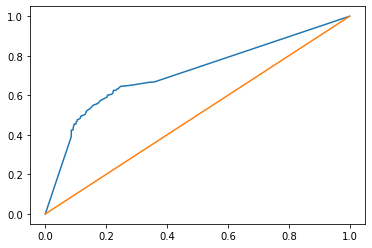

F1: 0.4932975871313673, ROC AUC: 0.713531997731023
Feature importances: 
 Age                0.243366
NumOfProducts      0.172343
EstimatedSalary    0.150024
CreditScore        0.129309
Balance            0.123278
Tenure             0.072681
IsActiveMember     0.045288
Geography          0.037735
Gender             0.017041
HasCrCard          0.008935
dtype: float64


In [27]:
decision_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 13, random_state=111)
decision_model.fit(features_ordinal_train, target_ordinal_train)
predicted_decision = decision_model.predict(features_ordinal_valid)
pred_des = decision_model.predict_proba(features_ordinal_valid)
des_one_valid = pred_des[:, 1]
decision_auc = roc_auc_score(target_ordinal_valid, des_one_valid)
fpr, tpr, thresholds = roc_curve(target_ordinal_valid, des_one_valid)
ft_imp = pd.Series(decision_model.feature_importances_, index=features_ordinal_train.columns).sort_values(ascending=False)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()
print("F1: {}, ROC AUC: {}".format(f1_score(target_ordinal_valid, predicted_decision), decision_auc))
print("Feature importances: \n", ft_imp)

<b>RandomForestClassifier</b>

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=222,
                       verbose=0, warm_start=False) 
 F1 на валидационных данных: 0.60
 Лучшая глубина: 13, 
 ROC AUC: 0.84


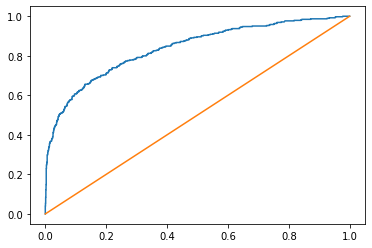

Age                0.250947
NumOfProducts      0.155815
EstimatedSalary    0.136712
CreditScore        0.130214
Balance            0.129986
Tenure             0.074290
IsActiveMember     0.046245
Geography          0.038139
Gender             0.019336
HasCrCard          0.018317
dtype: float64
CPU times: user 45.4 s, sys: 98.9 ms, total: 45.5 s
Wall time: 45.7 s


In [28]:
%%time
random_score = 0
random_model = None
random_depth = 0
for est in range(10, 100, 10):
    for i in range(1, 15, 1):
        random_model = RandomForestClassifier(n_estimators=est, random_state=222, max_depth=i)
        random_model.fit(features_ordinal_train, target_ordinal_train)
        predicted_random = random_model.predict(features_ordinal_valid)
        random_proba = random_model.predict_proba(features_ordinal_valid)
        random_one_valid = random_proba[:, 1]
        random_auc = roc_auc_score(target_ordinal_valid, random_one_valid)
        if f1_score(target_ordinal_valid, predicted_random) > random_score:
            random_score = f1_score(target_ordinal_valid, predicted_random)
            random_model = est
            random_depth = i
print('Лучшая модель: {} \n F1 на валидационных данных: {:.2f}\n Лучшая глубина: {}, \n ROC AUC: {:.2f}'.format(random_model, 
                                                                                                     random_score, 
                                                                                                     random_depth, 
                                                                                        random_auc))
fpr, tpr, thresholds = roc_curve(target_ordinal_valid, random_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()
ft_imp = pd.Series(random_model.feature_importances_, index=features_ordinal_train.columns).sort_values(ascending=False)
print(ft_imp)

<b>LogisticRegression</b>

F1 на валидационных данных: 0.10, ROC AUC: 0.68


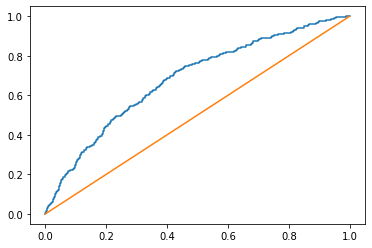

CPU times: user 364 ms, sys: 92.6 ms, total: 456 ms
Wall time: 475 ms


In [29]:
%%time
logistic_model = LogisticRegression(random_state=333, solver="liblinear") # class_weight='balanced'
logistic_model.fit(features_ohe_train, target_ohe_train)
predicted_log = logistic_model.predict(features_ohe_valid)
log_proba = logistic_model.predict_proba(features_ohe_valid)
log_one_valid = log_proba[:, 1]
logistic_auc = roc_auc_score(target_ohe_valid, log_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_log), logistic_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, log_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>SVC</b>

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 на валидационных данных: 0.00, ROC AUC: 0.50


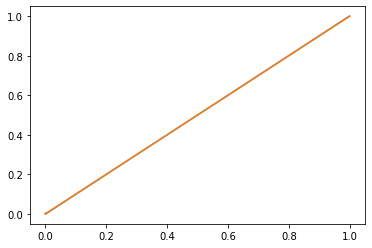

CPU times: user 10.9 s, sys: 393 ms, total: 11.3 s
Wall time: 11.3 s


In [30]:
%%time
svc_model = SVC(random_state=444, gamma='auto', probability=True) # class_weight='balanced'
svc_model.fit(features_ohe_train, target_ohe_train)
predicted_svc = svc_model.predict(features_ohe_valid)
svc_proba = svc_model.predict_proba(features_ohe_valid)
svc_one_valid = svc_proba[:, 1]
svc_auc = roc_auc_score(target_ohe_valid, svc_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_svc), svc_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, svc_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>GaussianNB</b>

F1 на валидационных данных: 0.14, ROC AUC: 0.74


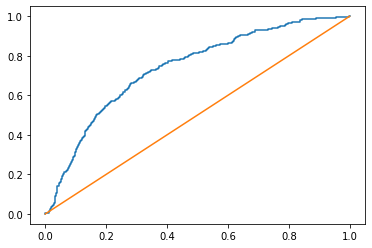

CPU times: user 321 ms, sys: 4.01 ms, total: 325 ms
Wall time: 345 ms


In [31]:
%%time
np.random.seed(555)
gauss_model = GaussianNB()
gauss_model.fit(features_ohe_train, target_ohe_train)
predicted_gauss = gauss_model.predict(features_ohe_valid)
gauss_proba = gauss_model.predict_proba(features_ohe_valid)
gauss_one_valid = gauss_proba[:, 1]
gauss_auc = roc_auc_score(target_ohe_valid, gauss_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_gauss), gauss_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, gauss_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>KNeighborsClassifier</b>

F1 на валидационных данных: 0.05, ROC AUC: 0.54, Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')


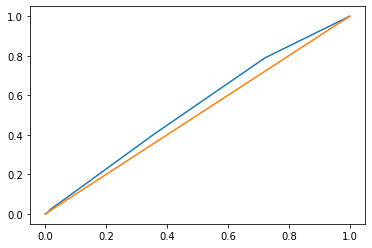

CPU times: user 927 ms, sys: 17 µs, total: 927 ms
Wall time: 935 ms


In [32]:
%%time
np.random.seed(666)
kn_model = None
kn_score = 0
for i in range(1, 7):
    kn_model = KNeighborsClassifier(n_neighbors=i)
    kn_model.fit(features_ohe_train, target_ohe_train)
    predicted_kn = kn_model.predict(features_ohe_valid)
    kn_proba = kn_model.predict_proba(features_ohe_valid)
    kn_one_valid = kn_proba[:, 1]
    kn_auc = roc_auc_score(target_ohe_valid, kn_one_valid)
    if f1_score(target_ohe_valid, predicted_kn) > kn_score:
        kn_score = f1_score(target_ohe_valid, predicted_kn)
        kn_model = i
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}, Model: {}'.format(f1_score(target_ohe_valid, predicted_kn), 
                                                                              kn_auc, 
                                                                              kn_model))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, kn_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>LinearDiscriminantAnalysis</b>

F1 на валидационных данных: 0.31, ROC AUC: 0.77


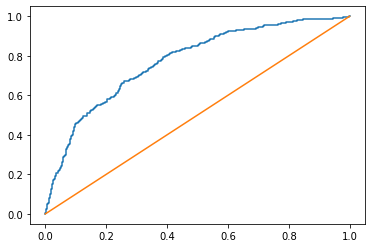

CPU times: user 352 ms, sys: 129 ms, total: 480 ms
Wall time: 501 ms


In [33]:
%%time
np.random.seed(777)
discrim_model = LinearDiscriminantAnalysis()
discrim_model.fit(features_ohe_train, target_ohe_train)
predicted_discrim = discrim_model.predict(features_ohe_valid)
discrim_proba = discrim_model.predict_proba(features_ohe_valid)
discrim_one_valid = discrim_proba[:, 1]
discrim_auc = roc_auc_score(target_ohe_valid, discrim_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_discrim), discrim_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, discrim_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>Выводы:</b>
* RandomForestClassifier - F1 на валидационных данных: 0.60, ROC AUC: 0.84
* DecisionTreeClassifier - F1 на валидационных данных: 0.57, ROC AUC: 0.70
* GaussianNB - F1 на валидационных данных: 0.44, ROC AUC: 0.78
* SVC - F1 на валидационных данных: 0.42, ROC AUC: 0.82

# 3. Борьба с дисбалансом

<b>Попробуем две модели с добавлением веса:</b>

F1 на валидационных данных: 0.48, ROC AUC: 0.77


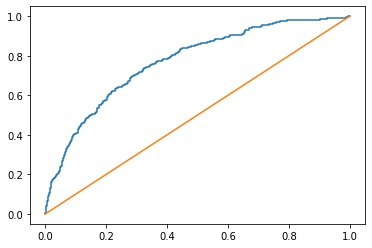

CPU times: user 353 ms, sys: 113 ms, total: 466 ms
Wall time: 482 ms


In [34]:
%%time
logistic_model = LogisticRegression(random_state=333, solver="liblinear", class_weight='balanced')
logistic_model.fit(features_ohe_train, target_ohe_train)
predicted_log = logistic_model.predict(features_ohe_valid)
log_proba = logistic_model.predict_proba(features_ohe_valid)
log_one_valid = log_proba[:, 1]
logistic_auc = roc_auc_score(target_ohe_valid, log_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_log), logistic_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, log_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 на валидационных данных: 0.00, ROC AUC: 0.50


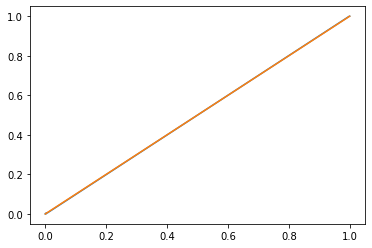

CPU times: user 11.5 s, sys: 465 ms, total: 12 s
Wall time: 12.2 s


In [35]:
%%time
svc_model = SVC(random_state=444, gamma='auto', class_weight='balanced', probability=True)
svc_model.fit(features_ohe_train, target_ohe_train)
predicted_svc = svc_model.predict(features_ohe_valid)
svc_proba = svc_model.predict_proba(features_ohe_valid)
svc_one_valid = svc_proba[:, 1]
svc_auc = roc_auc_score(target_ohe_valid, svc_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_svc), svc_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, svc_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>Немного увеличилось, но не дозодит до границы 0.59</b>

<b>Для начала отмасштабируем некоторые признаки для не tree моделей</b>

In [36]:
scaler.fit(features_ohe_train[numeric])
features_ohe_train.loc[:, numeric] = scaler.transform(features_ohe_train[numeric])
features_ohe_valid.loc[:, numeric] = scaler.transform(features_ohe_valid[numeric])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<b>Напишем функцию upsample, для увелиния количества меньшего класса</b>

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=98765)
    
    return features_upsampled, target_upsampled

In [38]:
print(target_ordinal_train.value_counts())
print(target_ohe_train.value_counts())

0    4762
1    1238
Name: Exited, dtype: int64
0    4781
1    1219
Name: Exited, dtype: int64


<b>Сделаем "1" класс в 3 раза больше</b>

In [39]:
features_ohe_upsampled, target_ohe_upsampled = upsample(features_ohe_train, target_ohe_train, 3)

In [40]:
features_ord_upsampled, target_ord_upsampled = upsample(features_ordinal_train, target_ordinal_train, 3)

In [41]:
print(target_ord_upsampled.value_counts())
print(target_ohe_upsampled.value_counts())

0    4762
1    3714
Name: Exited, dtype: int64
0    4781
1    3657
Name: Exited, dtype: int64


<b>Обучим модели снова и обновим результаты метрик</b>

<b>DecisionTreeClassifier</b>

Лучшая модель: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=111, splitter='best'), F1 на валидационных данных: 0.57, ROC AUC: 0.70


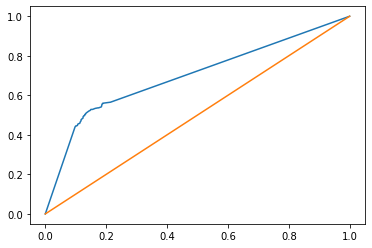

CPU times: user 884 ms, sys: 8.16 ms, total: 893 ms
Wall time: 893 ms


In [42]:
%%time
decision_score = 0
decision_model = None

for i in range(1, 15, 1):
    decision_model = DecisionTreeClassifier(max_depth=i, random_state=111)
    decision_model.fit(features_ord_upsampled, target_ord_upsampled)
    predicted_decision = decision_model.predict(features_ordinal_valid)
    decision_proba = decision_model.predict_proba(features_ordinal_valid)
    decision_one_valid = decision_proba[:, 1]
    decision_auc = roc_auc_score(target_ordinal_valid, decision_one_valid)
    if f1_score(target_ordinal_valid, predicted_decision) > decision_score:
        decision_score = f1_score(target_ordinal_valid, predicted_decision)
        decision_model = i
print('Лучшая модель: {}, F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(decision_model, decision_score, decision_auc))
fpr, tpr, thresholds = roc_curve(target_ordinal_valid, decision_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>RandomForestClassifier</b>

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=222,
                       verbose=0, warm_start=False) 
 F1 на валидационных данных: 0.62
 Лучшая глубина: 7, 
 ROC AUC: 0.84


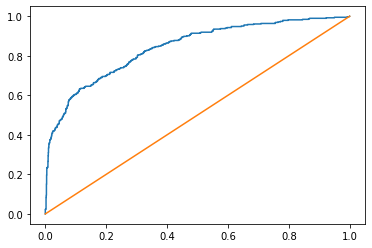

CPU times: user 1min 21s, sys: 141 ms, total: 1min 21s
Wall time: 1min 22s


In [43]:
%%time
random_score = 0
random_model = None
random_depth = 0
for est in range(10, 100, 10):
    for i in range(1, 15, 1):
        random_model = RandomForestClassifier(n_estimators=est, random_state=222, max_depth=i)
        random_model.fit(features_ord_upsampled, target_ord_upsampled)
        predicted_random = random_model.predict(features_ordinal_valid)
        random_proba = random_model.predict_proba(features_ordinal_valid)
        random_one_valid = random_proba[:, 1]
        random_auc = roc_auc_score(target_ordinal_valid, random_one_valid)
        if f1_score(target_ordinal_valid, predicted_random) > random_score:
            random_score = f1_score(target_ordinal_valid, predicted_random)
            random_model = est
            random_depth = i
print('Лучшая модель: {} \n F1 на валидационных данных: {:.2f}\n Лучшая глубина: {}, \n ROC AUC: {:.2f}'.format(random_model, 
                                                                                                     random_score, 
                                                                                                     random_depth, 
                                                                                        random_auc))
fpr, tpr, thresholds = roc_curve(target_ordinal_valid, random_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>Проверим метрики через threshold</b>

In [44]:
for threshold in np.arange(0.3, 0.8, 0.1):
    predicted_test = random_one_valid >= threshold
    print('F1 на тестовых данных: {:.2f}, ROC AUC: {:.2f}, Threshold: {}'.format(f1_score(target_ordinal_valid, predicted_test), 
                                                                   roc_auc_score(target_ordinal_valid, predicted_test), 
                                                                                 threshold))

F1 на тестовых данных: 0.54, ROC AUC: 0.75, Threshold: 0.3
F1 на тестовых данных: 0.57, ROC AUC: 0.75, Threshold: 0.4
F1 на тестовых данных: 0.60, ROC AUC: 0.75, Threshold: 0.5
F1 на тестовых данных: 0.57, ROC AUC: 0.71, Threshold: 0.6000000000000001
F1 на тестовых данных: 0.54, ROC AUC: 0.69, Threshold: 0.7000000000000002


<b>LogisticRegression</b>

F1 на валидационных данных: 0.47, ROC AUC: 0.77


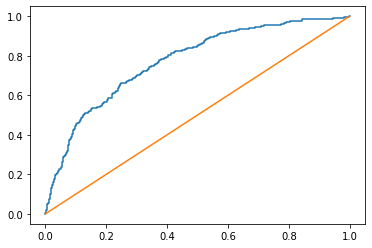

CPU times: user 354 ms, sys: 88.5 ms, total: 443 ms
Wall time: 474 ms


In [237]:
%%time
logistic_model = LogisticRegression(random_state=333, solver="liblinear") # class_weight='balanced'
logistic_model.fit(features_ohe_upsampled, target_ohe_upsampled)
predicted_log = logistic_model.predict(features_ohe_valid)
log_proba = logistic_model.predict_proba(features_ohe_valid)
log_one_valid = log_proba[:, 1]
logistic_auc = roc_auc_score(target_ohe_valid, log_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_log), logistic_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, log_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>SVC</b>

F1 на валидационных данных: 0.59, ROC AUC: 0.84


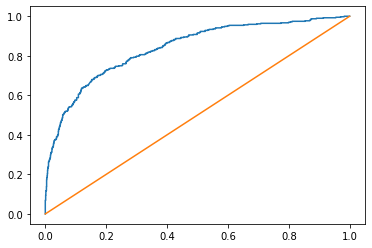

CPU times: user 16 s, sys: 91.8 ms, total: 16.1 s
Wall time: 16.4 s


In [238]:
%%time
svc_model = SVC(random_state=444, gamma='auto', probability=True)
svc_model.fit(features_ohe_upsampled, target_ohe_upsampled)
predicted_svc = svc_model.predict(features_ohe_valid)
svc_proba = svc_model.predict_proba(features_ohe_valid)
svc_one_valid = svc_proba[:, 1]
svc_auc = roc_auc_score(target_ohe_valid, svc_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_svc), svc_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, svc_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>Попробуем с регулировкой порога:</b>

In [239]:
probabilities_valid = svc_model.predict_proba(features_ohe_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.3, 0.8, 0.1):
    predicted_test = (svc_one_valid > threshold)
    print('F1 на тестовых данных: {:.2f}, ROC AUC: {:.2f}, Threshold: {}'.format(f1_score(target_ohe_valid, predicted_svc), 
                                                                   roc_auc_score(target_ohe_valid, svc_one_valid), threshold))

F1 на тестовых данных: 0.59, ROC AUC: 0.84, Threshold: 0.3
F1 на тестовых данных: 0.59, ROC AUC: 0.84, Threshold: 0.4
F1 на тестовых данных: 0.59, ROC AUC: 0.84, Threshold: 0.5
F1 на тестовых данных: 0.59, ROC AUC: 0.84, Threshold: 0.6000000000000001
F1 на тестовых данных: 0.59, ROC AUC: 0.84, Threshold: 0.7000000000000002


<b>GaussianNB</b>

F1 на валидационных данных: 0.49, ROC AUC: 0.78


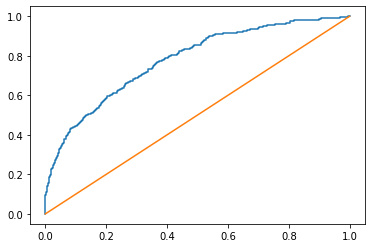

CPU times: user 251 ms, sys: 8 ms, total: 259 ms
Wall time: 274 ms


In [240]:
%%time
np.random.seed(555)
gauss_model = GaussianNB()
gauss_model.fit(features_ohe_upsampled, target_ohe_upsampled)
predicted_gauss = gauss_model.predict(features_ohe_valid)
gauss_proba = gauss_model.predict_proba(features_ohe_valid)
gauss_one_valid = gauss_proba[:, 1]
gauss_auc = roc_auc_score(target_ohe_valid, gauss_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_gauss), gauss_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, gauss_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>KNeighborsClassifier</b>

F1 на валидационных данных: 0.46, ROC AUC: 0.74, Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')


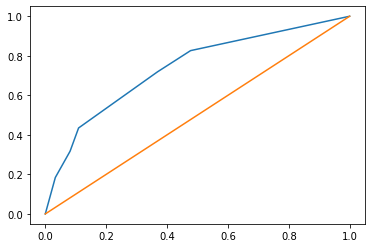

CPU times: user 1.97 s, sys: 3.96 ms, total: 1.98 s
Wall time: 1.99 s


In [241]:
%%time
np.random.seed(666)
kn_model = None
kn_score = 0
for i in range(1, 7):
    kn_model = KNeighborsClassifier(n_neighbors=i)
    kn_model.fit(features_ohe_upsampled, target_ohe_upsampled)
    predicted_kn = kn_model.predict(features_ohe_valid)
    kn_proba = kn_model.predict_proba(features_ohe_valid)
    kn_one_valid = kn_proba[:, 1]
    kn_auc = roc_auc_score(target_ohe_valid, kn_one_valid)
    if f1_score(target_ohe_valid, predicted_kn) > kn_score:
        kn_score = f1_score(target_ohe_valid, predicted_kn)
        kn_model = i
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}, Model: {}'.format(f1_score(target_ohe_valid, predicted_kn), 
                                                                              kn_auc, 
                                                                              kn_model))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, kn_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>LinearDiscriminantAnalysis</b>

F1 на валидационных данных: 0.48, ROC AUC: 0.77


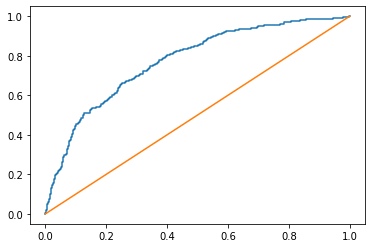

CPU times: user 369 ms, sys: 149 ms, total: 517 ms
Wall time: 537 ms


In [242]:
%%time
np.random.seed(777)
discrim_model = LinearDiscriminantAnalysis()
discrim_model.fit(features_ohe_upsampled, target_ohe_upsampled)
predicted_discrim = discrim_model.predict(features_ohe_valid)
discrim_proba = discrim_model.predict_proba(features_ohe_valid)
discrim_one_valid = discrim_proba[:, 1]
discrim_auc = roc_auc_score(target_ohe_valid, discrim_one_valid)
print('F1 на валидационных данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(target_ohe_valid, predicted_discrim), discrim_auc))
fpr, tpr, thresholds = roc_curve(target_ohe_valid, discrim_one_valid)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>Выводы</b>

| Model | F1 до upsample/scaling | ROC до upsample/scaling | F1 после upsample/scaling | ROC после upsample/scaling |
| --- | --- | --- | --- | --- |
| SVC | 0.42 | 0.82 | 0.61 | 0.77 |
| RandomForestClassifier | 0.60 | 0.84 | 0.61 | 0.74 |
| DecisionTreeClassifier | 0.57 | 0.70 | 0.57 | 0.68 |
| GaussianNB | 0.44 | 0.78 | 0.49 | 0.70 |
| LinearDiscriminantAnalysis | 0.31 | 0.77 | 0.48 | 0.69 |
| KNeighborsClassifier | 0.32 | 0.75 | 0.48 | 0.67 |
| LogisticRegression | 0.31 | 0.77 | 0.47 | 0.77 |


Балансировка с масштабированием значительно улучшила показатели метрик, теперь посмотрим на тестовых данных

# 4. Тестирование модели

<b>Возьмём двух финалистов и сравним их результаты на тестовой выборке</b>

<b>RandomForestClassifier</b>

In [243]:
train_ordinal, target_ordinal = upsample(ordinal_features, ordinal_target, 3)

F1 на тестовых данных: 0.58, ROC AUC: 0.86
Precision: 0.582
Recall: 0.583


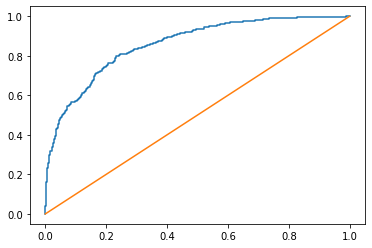

CPU times: user 1.32 s, sys: 8.03 ms, total: 1.32 s
Wall time: 1.35 s


In [244]:
%%time
random_model = RandomForestClassifier(n_estimators=90, random_state=222, max_depth=8)
random_model.fit(train_ordinal, target_ordinal)
predicted_random = random_model.predict(test_ordinal_features)
random_proba = random_model.predict_proba(test_ordinal_features)
random_one_test = random_proba[:, 1]
random_auc = roc_auc_score(test_ordinal_target, random_one_test)
print('F1 на тестовых данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(test_ordinal_target, predicted_random), 
                                                                                                     random_auc))
print("Precision: {:.3f}".format(precision_score(test_ordinal_target, predicted_random)))
print("Recall: {:.3f}".format(recall_score(test_ordinal_target, predicted_random)))
fpr, tpr, thresholds = roc_curve(test_ordinal_target, random_one_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>SVC с масштабированием тестовых данных</b>

<b>Подготовим обобщённую выборку</b>

In [245]:
train_upsampled, target_upsampled = upsample(ohe_features, ohe_target, 3)

In [246]:
scaler.fit(test_ohe_features[numeric])
test_ohe_features[numeric] = scaler.transform(test_ohe_features[numeric])
scaler.fit(train_upsampled[numeric])
train_upsampled[numeric] = scaler.transform(train_upsampled[numeric])

F1 на тестовых данных: 0.63, ROC AUC: 0.86
Precision: 0.561
Recall: 0.717


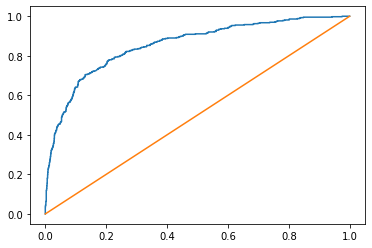

CPU times: user 28.1 s, sys: 464 ms, total: 28.6 s
Wall time: 28.9 s


In [247]:
%%time
svc_model = SVC(random_state=141, gamma='auto', probability=True)
svc_model.fit(train_upsampled, target_upsampled)
predicted_svc = svc_model.predict(test_ohe_features)
svc_proba = svc_model.predict_proba(test_ohe_features)
svc_one_test = svc_proba[:, 1]
svc_auc = roc_auc_score(test_ohe_target, svc_one_test)
print('F1 на тестовых данных: {:.2f}, ROC AUC: {:.2f}'.format(f1_score(test_ohe_target, predicted_svc), svc_auc))
print("Precision: {:.3f}".format(precision_score(test_ohe_target, predicted_svc)))
print("Recall: {:.3f}".format(recall_score(test_ohe_target, predicted_svc)))
fpr, tpr, thresholds = roc_curve(test_ohe_target, svc_one_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

<b>Итоговый вывод:</b>

| Model | F1 с upsample/scaling | ROC с upsample/scaling | F1 после теста | ROC после теста | Precision | Recall |
| --- | --- | --- | --- | --- | --- | --- |
| SVC | 0.61 | 0.77 | 0.63 | 0.86 | 0.56 | 0.71 |
| RandomForestClassifier | 0.61 | 0.74 | 0.58 | 0.86 | 0.58 | 0.58 |

* Семплирование имеет чуствительность: от 2 до 4 возникает переобучение и недообучение. Оптимальным выбрал - **3 повтора**
* C небольшим отрывом лидером стал **SVC**. Обучение моделей было на обобщённой выборке
* SVC с recall 0.71 имеет меньше шансов ошибиться с предсказанием ухода клиента
* При пропусках, заполненных **медианой / средним / -1** выдаёт те же значения
* Регулировка threshold не повлияла на увеличение метрик посе масштабирования и семплирования